# neurODE: Spring Model

This file implements the neurODE training strategy for training and analyzing a biochemically mechanistic model of neural firing (see github.com/samuelbray32/dualChannelRNN or upcoming paper for details of mechanism). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import keras

Using TensorFlow backend.


# Define Model
You have a few options here.
 - build_model: start a new model from scratch. will take longer to train
 - load model in directory: take a model you've trained already here and reload to explore
 - load model from robustness paper: start from one of the many models from our last paper trained on WT and knockdown stimulus data. Recommended starting point for new training


In [ ]:
#start a model from scratch (follow this import or see github.com/samuelbray32/dualChannelRNN for details on architecture)
n_neuron=50**2
folder = './test/'
from tools.buildModel import buildModel
model, latent_model, theta = buildModel(folder,n_neuron=n_neuron,noise=1e-3,
                                        n_peptide=2)

In [2]:
#load model trained in this directory
n_neuron=50**2
from tools.model import load_model
folder = 'trainedModels/120522_neural_trainedOscillator/'
model,latent_model = load_model(folder,return_latent_model=True)

pep_space (?, 50, 50, 2)
pep_space (?, 50, 50, 2)
pep_space (?, 50, 50, 2)
pep_space (?, 50, 50, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [2]:
#load trained model from robustness paper
n_neuron=50**2
from tools.model import load_model
folder = '../../../../media/sam/internal_2/behavior/dualNet/v051122_STAGE3_deepScreen/'
folder += 'WS_k8_beta0.001_noise0.001/'
model,latent_model = load_model(folder,return_latent_model=True)

pep_space (?, 50, 50, 2)
pep_space (?, 50, 50, 2)
pep_space (?, 50, 50, 2)
pep_space (?, 50, 50, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# Training

Currently more manually defined as we figure out what data we're using for this next paper

### Make training data

dict_keys(['tau', '093022WT_30m_1mPeriod', '093022WT_30m_3mPeriod', '093022WT_30m_10mPeriod', '093022WT_30m_30sPeriod', '093022WT_30m_2mPeriod', '093022WT_30m_5mPeriod', '100622WT_30m_5mPeriod', '100622WT_30m_4mPeriod', '101422WT_30m_6mPeriod', '101422WT_30m_8mPeriod', '101422WT_30m_9mPeriod', '101822WT_30m_3mPeriod_amp64bp', '101822WT_30m_2mPeriod_amp64bp', '101722WT_30m_11mPeriod', '101722WT_30m_10mPeriod', '101722WT_30m_2mPeriod_amp32bp', '101722WT_30m_3mPeriod_amp32bp', '101722WT_30m_4mPeriod_amp32bp', '102122WT_30m_15mPeriod', '102122WT_30m_13mPeriod', '102122WT_30m_12mPeriod', '102422WT_30m_150sPeriod', '102422WT_30m_210sPeriod', '102422WT_30m_270sPeriod', '102422WT_30m_330sPeriod', '102422bWT_30m_5mPeriod', '102422aWT_30m_5mPeriod', '101822pc2_30m_10mPeriod', '101822pc2_30m_3mPeriod'])
WT_30m_30s
['093022WT_30m_30sPeriod']
WT_30m_1m
['093022WT_30m_1mPeriod']
WT_30m_2m
['093022WT_30m_2mPeriod']
WT_30m_150s
['102422WT_30m_150sPeriod']
WT_30m_3m
['093022WT_30m_3mPeriod']
WT_30m_210

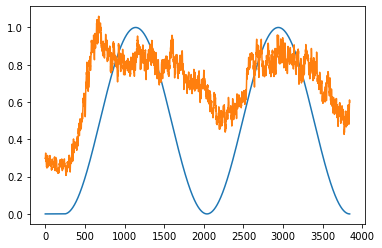

In [3]:
'''make training data'''

interest='WT'
periods = [.5,1,2,2.5,3,3.5,4,4.5,5,6,8,9,10,11,12,13,15]
duration=30
UU = []
ZZ = []

import pickle
def data_of_interest(names,interest=[],exclude=[]):
    to_plot = []
    full_amp = True
    for i in interest:
        if 'amp' in i and not '127amp' in i:
            full_amp=False
    if full_amp:
        exclude.append('amp')
    for dat in names:
        if dat in to_plot: continue
        for i in interest:
            if i in dat:
                keep = True
                for ex in exclude:
                    if ex in dat: keep = False
                #check double/triple knockdown
                if dat.count('+')>i.count('+'):
                    print(dat)
                    keep=False
                if keep: to_plot.append(dat)
    return to_plot

name = 'data/LDS_response_sinFunc.pickle'
with open(name,'rb') as f:
    result = pickle.load(f)
print(result.keys())
for i,p in enumerate(periods):
    xp = result['tau']
    ind_t = np.where((xp>=-2)&(xp<=30))[0]
    p_name = f'{p}m'
    if p<1 or p%1>0:
        p_name = f'{int(p*60)}s'

    print(f'{interest}_{duration}m_{p_name}')
    to_plot = data_of_interest(result.keys(),[f'{interest}_{duration}m_{p_name}'],)
    print(to_plot)
    xp = result['tau']
    yp = np.concatenate([result[dat]['data'] for dat in to_plot])
    
    UU.append(np.array([ind_t*0,result[to_plot[0]]['stim'][ind_t]]).T)
    ZZ.append(np.median(yp,axis=0)[ind_t])
plt.plot(UU[-1][:,1])
plt.plot(ZZ[-1])

augment=10
UU = np.concatenate([UU for i in range(augment)])[...,1][...,None]
ZZ = np.concatenate([ZZ for i in range(augment)])

UU_gene = np.ones((UU.shape[0],1))*1
UU_ablate = np.ones((UU.shape[0],n_neuron))
UU_syn = UU_ablate.copy()

###  Fit Model

Feel free to play with optimizers.  Beware of exploding gradients (i.e. USE clipnorm or clipval!!!)

In [279]:
import keras
# opt = keras.optimizers.Adam(learning_rate=1e-6,clipnorm=1e-3)#keras.optimizers.Adadelta(learning_rate=1e-3)#
opt = keras.optimizers.Adadelta(learning_rate=1e-6,clipnorm=1e-4)
model.compile(optimizer=opt,loss='mse')
    
ind = np.arange(UU.shape[0])
np.random.shuffle(ind)
model.fit(x=[UU[ind],UU_gene[ind],UU_ablate[ind],UU_syn[ind]],y=ZZ[ind],epochs=100,shuffle=True,
              callbacks=[],batch_size=8,)

Epoch 1/100
170/170 [==============================] - 337s 2s/step - loss: 0.0357
Epoch 2/100
170/170 [==============================] - 339s 2s/step - loss: 0.0357
Epoch 3/100
170/170 [==============================] - 341s 2s/step - loss: 0.0357
Epoch 4/100
170/170 [==============================] - 338s 2s/step - loss: 0.0357
Epoch 5/100
170/170 [==============================] - 313s 2s/step - loss: 0.0357
Epoch 6/100
170/170 [==============================] - 338s 2s/step - loss: 0.0357
Epoch 7/100
170/170 [==============================] - 335s 2s/step - loss: 0.0357
Epoch 8/100
170/170 [==============================] - 335s 2s/step - loss: 0.0357
Epoch 9/100
170/170 [==============================] - 318s 2s/step - loss: 0.0357
Epoch 10/100
170/170 [==============================] - 316s 2s/step - loss: 0.0357
Epoch 11/100
170/170 [==============================] - 332s 2s/step - loss: 0.0357
Epoch 12/100
170/170 [==============================] - 330s 2s/step - loss: 0.0357
E

### Predict
Check your fit results

In [4]:
n=len(periods)
z_pred = model.predict([UU[:n],UU_gene[:n],UU_ablate[:n],UU_syn[:n]],batch_size=n)


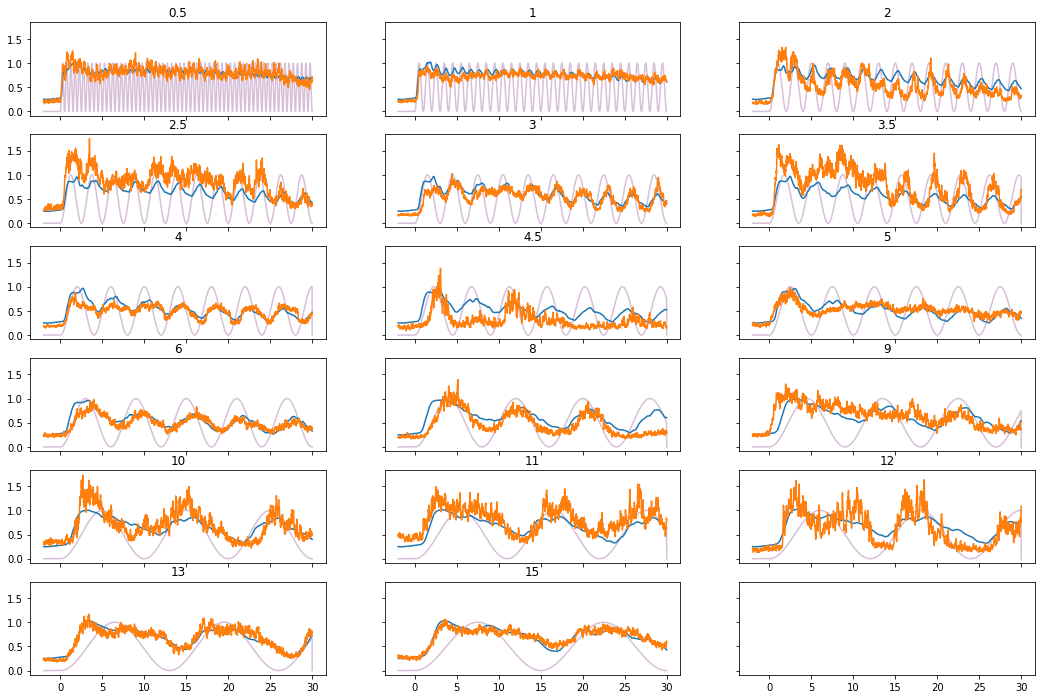

In [6]:
%matplotlib inline
# fig=plt.figure(figsize=(12,8))
# i=1
# plt.plot(z_pred[i])
# plt.plot(ZZ[i])
# plt.plot(UU[i])
# plt.title(periods[i])

fig,ax=plt.subplots(figsize=(18,12),nrows=6,ncols=3,sharex=True,sharey=True)
ax = np.ravel(ax)
tp = xp[ind_t]
for i, a in enumerate(ax):
    if i>=z_pred.shape[0]: break
    a.plot(tp,z_pred[i])
    a.plot(tp,ZZ[i])
    a.plot(tp,UU[i],c='thistle',zorder=-2)
    a.set_title(periods[i])
#     a.set_ylim(.4,1.4)

# Model Analysis

Now that we have a trained model, we want to study what it does, and how the underlying neural dynamics generate this behavior. 

### Spectral Response
What is the amplitude of behavior response oscillations at different driving frequencies

10/10 [==============================] - 5s 499ms/step


9it [00:01,  4.08it/s]/home/sam/Desktop/NeuralTrainining/tools/analyzeNeural.py:38: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.array([np.cov(xx[t:],U[:-t])[0,1] for t in tau])
/home/sam/anaconda3/envs/imgBehavior-tf/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/sam/anaconda3/envs/imgBehavior-tf/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
10it [00:01,  5.48it/s]


10/10 [==============================] - 5s 512ms/step


10it [00:01,  5.57it/s]


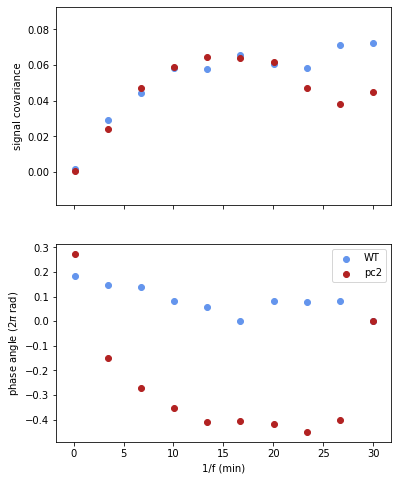

In [20]:
import importlib
import tools #import the module here, so that it can be reloaded.
importlib.reload(tools.analyzeNeural)

from tools.analyzeNeural import spectralResponse
spectrum = np.linspace(0.1,30,10)
# spectrum = np.append(spectrum,np.logspace(-1,1.5,50))
spectrum.sort()
spectrum=np.unique(spectrum)
t = np.arange(-3,60,1/120)
# fig,ax=spectralResponse(model,test_spectrum=spectrum, resolution=2)

fig,ax,spectrum, amp, phase, z,U=spectralResponse(model,test_spectrum=spectrum,
                                                return_all=True,resolution=1,
                                               label='WT',color='cornflowerblue',t=t)
fig,ax,spectrum, amp_pc2, phase_pc2, z_pc2, U=spectralResponse(model,test_spectrum=spectrum,
                                                return_all=True,resolution=1,
                                               peptides=0, figure=(fig,ax),
                                               label='pc2',color='firebrick',t=t)

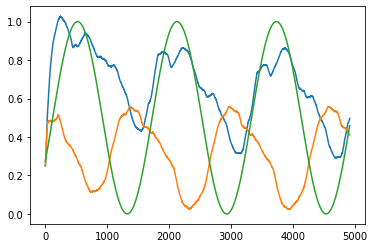

In [23]:
plt.plot(z[4])
plt.plot(z_pc2[4])
plt.plot(U[4])

#### spectral response with ablation

In [127]:
import importlib
import tools #import the module here, so that it can be reloaded.
importlib.reload(tools.analyzeNeural)
importlib.reload(tools.model)

from tools.analyzeNeural import spectralResponse_ablation

test_spectrum= np.linspace(.1,15,20)
ablation = np.linspace(0,.75,5)
n_ablate=32
resolution=3
spectralResponse_ablation(model,test_spectrum=test_spectrum,n_ablate=n_ablate,
                         resolution=resolution,batch_size=32)

ablation [0.    0.125 0.25  0.375 0.5  ]


/home/sam/Desktop/NeuralTrainining/tools/analyzeNeural.py:80: RuntimeWarning: divide by zero encountered in true_divide
  U_test = np.sin(t/i*2*np.pi)/2+.5
/home/sam/Desktop/NeuralTrainining/tools/analyzeNeural.py:80: RuntimeWarning: invalid value encountered in sin
  U_test = np.sin(t/i*2*np.pi)/2+.5


32/32 [==============================] - 5s 145ms/step


0it [00:00, ?it/s]/home/sam/Desktop/NeuralTrainining/tools/analyzeNeural.py:109: RuntimeWarning: All-NaN slice encountered
  amp_ablate[-1].append(np.nanmax(corr))
32it [00:00, 863.56it/s]


32/32 [==============================] - 5s 142ms/step


32it [00:00, 175.94it/s]


32/32 [==============================] - 5s 146ms/step


32it [00:00, 64.05it/s]


32/32 [==============================] - 5s 141ms/step


32it [00:00, 46.14it/s]


32/32 [==============================] - 4s 140ms/step


32it [00:01, 20.14it/s]


32/32 [==============================] - 5s 148ms/step


32it [00:00, 50.65it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:01, 27.56it/s]


32/32 [==============================] - 5s 157ms/step


32it [00:01, 16.37it/s]


32/32 [==============================] - 5s 141ms/step


32it [00:01, 16.64it/s]


32/32 [==============================] - 5s 150ms/step


32it [00:01, 22.70it/s]


32/32 [==============================] - 5s 143ms/step


32it [00:01, 23.01it/s]


32/32 [==============================] - 5s 141ms/step


32it [00:02, 15.90it/s]


32/32 [==============================] - 4s 140ms/step


32it [00:02, 11.03it/s]


32/32 [==============================] - 5s 143ms/step


32it [00:01, 18.16it/s]


32/32 [==============================] - 5s 148ms/step


32it [00:02, 14.83it/s]


32/32 [==============================] - 5s 146ms/step


32it [00:02, 12.02it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:02, 12.39it/s]


32/32 [==============================] - 5s 145ms/step


32it [00:02, 11.20it/s]


32/32 [==============================] - 5s 151ms/step


32it [00:02, 11.39it/s]


32/32 [==============================] - 5s 151ms/step


32it [00:03,  9.37it/s]
/home/sam/anaconda3/envs/imgBehavior-tf/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)
No handles with labels found to put in legend.


32/32 [==============================] - 5s 146ms/step


32it [00:00, 906.01it/s]


32/32 [==============================] - 5s 151ms/step


32it [00:00, 108.20it/s]


32/32 [==============================] - 5s 165ms/step


32it [00:00, 112.65it/s]


32/32 [==============================] - 5s 168ms/step


32it [00:02, 13.98it/s]


32/32 [==============================] - 6s 182ms/step


32it [00:01, 27.28it/s]


32/32 [==============================] - 5s 151ms/step


32it [00:04,  7.32it/s]


32/32 [==============================] - 7s 208ms/step


32it [00:00, 32.65it/s]


32/32 [==============================] - 5s 147ms/step


32it [00:01, 18.79it/s]


32/32 [==============================] - 5s 149ms/step


32it [00:01, 19.70it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:02, 12.39it/s]


32/32 [==============================] - 5s 145ms/step


32it [00:03,  9.42it/s]


32/32 [==============================] - 7s 203ms/step


32it [00:06,  5.01it/s]


32/32 [==============================] - 5s 148ms/step


32it [00:03, 10.09it/s]


32/32 [==============================] - 7s 219ms/step


32it [00:03,  9.51it/s]


32/32 [==============================] - 5s 146ms/step


32it [00:02, 15.97it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:02, 11.74it/s]


32/32 [==============================] - 5s 151ms/step


32it [00:03,  8.43it/s]


32/32 [==============================] - 5s 157ms/step


32it [00:02, 10.90it/s]


32/32 [==============================] - 5s 143ms/step


32it [00:01, 19.01it/s]


32/32 [==============================] - 5s 145ms/step


32it [00:02, 13.48it/s]
No handles with labels found to put in legend.


32/32 [==============================] - 5s 146ms/step


32it [00:00, 960.93it/s]


32/32 [==============================] - 5s 150ms/step


32it [00:00, 159.31it/s]


32/32 [==============================] - 5s 156ms/step


32it [00:01, 22.89it/s]


32/32 [==============================] - 5s 152ms/step


32it [00:00, 69.66it/s]


32/32 [==============================] - 6s 176ms/step


32it [00:01, 25.50it/s]


32/32 [==============================] - 5s 150ms/step


32it [00:01, 21.14it/s]


32/32 [==============================] - 5s 147ms/step


32it [00:00, 32.44it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:01, 17.97it/s]


32/32 [==============================] - 5s 142ms/step


32it [00:01, 17.18it/s]


32/32 [==============================] - 5s 154ms/step


32it [00:02, 13.05it/s]


32/32 [==============================] - 5s 143ms/step


32it [00:02, 13.74it/s]


32/32 [==============================] - 4s 141ms/step


32it [00:02, 14.18it/s]


32/32 [==============================] - 5s 143ms/step


32it [00:02, 14.10it/s]


32/32 [==============================] - 5s 142ms/step


32it [00:02, 14.53it/s]


32/32 [==============================] - 5s 152ms/step


32it [00:03,  9.10it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:02, 11.14it/s]


32/32 [==============================] - 6s 177ms/step


32it [00:03,  8.80it/s]


32/32 [==============================] - 5s 171ms/step


32it [00:03,  9.65it/s]


32/32 [==============================] - 5s 147ms/step


32it [00:02, 10.83it/s]


32/32 [==============================] - 5s 151ms/step


32it [00:04,  7.39it/s]
No handles with labels found to put in legend.


32/32 [==============================] - 5s 165ms/step


32it [00:00, 496.27it/s]


32/32 [==============================] - 5s 154ms/step


32it [00:00, 110.62it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:00, 70.66it/s] 


32/32 [==============================] - 5s 148ms/step


32it [00:00, 42.29it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:00, 58.63it/s]


32/32 [==============================] - 5s 149ms/step


32it [00:01, 30.49it/s]


32/32 [==============================] - 5s 147ms/step


32it [00:01, 20.31it/s]


32/32 [==============================] - 5s 148ms/step


32it [00:01, 17.27it/s]


32/32 [==============================] - 5s 145ms/step


32it [00:01, 23.32it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:02, 14.22it/s]


32/32 [==============================] - 5s 146ms/step


32it [00:01, 25.06it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:02, 11.67it/s]


32/32 [==============================] - 5s 153ms/step


32it [00:02, 14.36it/s]


32/32 [==============================] - 5s 142ms/step


32it [00:01, 16.78it/s]


32/32 [==============================] - 5s 150ms/step


32it [00:02, 14.94it/s]


32/32 [==============================] - 5s 142ms/step


32it [00:02, 12.19it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:02, 11.51it/s]


32/32 [==============================] - 5s 156ms/step


32it [00:04,  7.49it/s]


32/32 [==============================] - 8s 252ms/step


32it [00:05,  6.08it/s]


32/32 [==============================] - 5s 155ms/step


32it [00:03,  9.66it/s]
No handles with labels found to put in legend.


32/32 [==============================] - 5s 152ms/step


32it [00:00, 887.38it/s]


32/32 [==============================] - 5s 144ms/step


32it [00:00, 88.63it/s] 


32/32 [==============================] - 5s 145ms/step


32it [00:00, 34.04it/s]


32/32 [==============================] - 5s 154ms/step


32it [00:01, 21.57it/s]


32/32 [==============================] - 6s 181ms/step


32it [00:02, 14.96it/s]


32/32 [==============================] - 5s 163ms/step


32it [00:02, 11.63it/s]


32/32 [==============================] - 6s 196ms/step


32it [00:01, 16.91it/s]


32/32 [==============================] - 6s 173ms/step


32it [00:02, 15.38it/s]


32/32 [==============================] - 5s 153ms/step


32it [00:02, 13.50it/s]


32/32 [==============================] - 5s 148ms/step


32it [00:01, 16.21it/s]


32/32 [==============================] - 5s 148ms/step


32it [00:02, 14.63it/s]


32/32 [==============================] - 5s 147ms/step


32it [00:03,  9.44it/s]


32/32 [==============================] - 5s 142ms/step


32it [00:02, 10.83it/s]


32/32 [==============================] - 5s 155ms/step


32it [00:04,  7.40it/s]


32/32 [==============================] - 5s 143ms/step


32it [00:02, 13.10it/s]


32/32 [==============================] - 5s 162ms/step


32it [00:03,  9.15it/s]


32/32 [==============================] - 8s 251ms/step


32it [00:06,  4.61it/s]


32/32 [==============================] - 5s 157ms/step


32it [00:03, 10.56it/s]


32/32 [==============================] - 5s 146ms/step


32it [00:03, 10.63it/s]


32/32 [==============================] - 5s 142ms/step


32it [00:02, 12.48it/s]
No handles with labels found to put in legend.


(<Figure size 600x800 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2438290c90>,
       dtype=object))

### Noise Covariance

Can we observe natural frequencies in the autocovariance of the behavioral output in response to white noise?

100/100 [==============================] - 84s 844ms/step


  0%|          | 0/100 [00:00<?, ?it/s]/home/sam/anaconda3/envs/imgBehavior-tf/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/sam/anaconda3/envs/imgBehavior-tf/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/sam/Desktop/NeuralTrainining/tools/analyzeNeural.py:168: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.array([np.cov(x[t:],x[:-t])[0,1] for t in tau])
/home/sam/anaconda3/envs/imgBehavior-tf/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/sam/anaconda3/envs/imgBehavior-tf/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
100%|██████████| 100/100 [00:10<00:00,  9.65it/

100/100 [==============================] - 86s 864ms/step


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


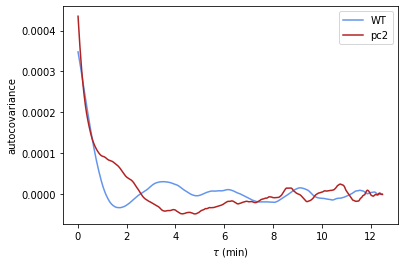

In [6]:
# import importlib
# import tools #import the module here, so that it can be reloaded.
# importlib.reload(tools.analyzeNeural)
from tools.analyzeNeural import noise_autocovariance
%matplotlib inline
t_test=60
n_test=100
fig,ax = noise_autocovariance(model, n_test=n_test,peptides=1,label='WT',
                             c='cornflowerblue')
fig,ax = noise_autocovariance(model, n_test=n_test,peptides=0,label='pc2',
                             c='firebrick',figure=(fig,ax))

#### Noise covariance with ablation

In [8]:
import importlib
import tools #import the module here, so that it can be reloaded.
importlib.reload(tools.analyzeNeural)
from tools.analyzeNeural import noise_autocovariance_ablation
%matplotlib qt

n_test=200
tau = np.arange(1,120*15,30)
ablation = np.linspace(0,.5,5)
fig,ax = noise_autocovariance_ablation(model, n_test=n_test,peptides=1,
                                      tau=tau,ablation=ablation,batch_size=16)

200/200 [==============================] - 62s 308ms/step


No handles with labels found to put in legend.


200/200 [==============================] - 59s 297ms/step


No handles with labels found to put in legend.


200/200 [==============================] - 60s 301ms/step


No handles with labels found to put in legend.


200/200 [==============================] - 59s 297ms/step


No handles with labels found to put in legend.


200/200 [==============================] - 59s 296ms/step


No handles with labels found to put in legend.


### Latent Dynamics

Visualizer of the neural firing under different driving frequencies

\* *note: displays in pop-out window to allow easy interaction*

In [9]:
# import importlib
# import tools #import the module here, so that it can be reloaded.
# importlib.reload(tools.analyzeNeural)
# importlib.reload(tools.model)
from tools.analyzeNeural import dynamics_slider
%matplotlib qt
fig, ax = dynamics_slider(latent_model)

4/4 [==============================] - 3s 719ms/step


### PCA

First approach at reducing the high-dimensional space space of firing dynamics into something interpretable. Consider non-linear methods in the future?

First build the fit pca object and show projected timeseries


In [5]:
import importlib
import tools #import the module here, so that it can be reloaded.
importlib.reload(tools.analyzeNeural)
from tools.analyzeNeural import firing_pca_fit
pca,x,u = firing_pca_fit(latent_model,return_data=True)
pca.explained_variance_ratio_

4/4 [==============================] - 3s 761ms/step


array([0.7751147 , 0.1529122 , 0.03024447, 0.00966914, 0.00853635,
       0.00673591, 0.00414375, 0.0022154 , 0.00189447, 0.00137045],
      dtype=float32)

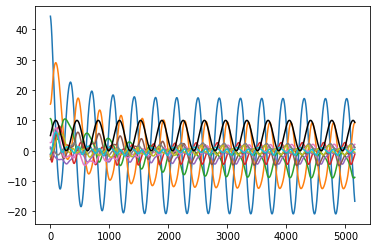

In [12]:
%matplotlib inline
i=0
y = pca.transform(x[i])
plt.plot(y)
plt.plot(u[i]*10,c='k')


#### Oscillating cycles

Explore the trajectories of the neural dynamics in reduced space

* *note: for 3D plots, just list >2 dimensions. You'll want to include the qt magic line to be able to play with viewing angle*

In [19]:
import importlib
import tools #import the module here, so that it can be reloaded.
importlib.reload(tools.analyzeNeural)
importlib.reload(tools.model)
from tools.analyzeNeural import pca_cycles
%matplotlib qt
pca_cycles(latent_model,model,dim=(0,1,),pca=pca,syn_gene='gad',peptides=1)

0.8752
4/4 [==============================] - 3s 727ms/step


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c00b0c150>)

# Workshop

place to play with new ideas before implementing them all pretty

Text(0, 0.5, 'cycle orientation ($\\pi$ rad)')

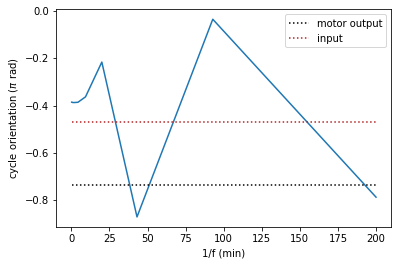

In [453]:
def orientation(data, angle=np.linspace(-1,0,2000)*np.pi):
    ranges=[]
    for a in angle:
        v = np.array([np.cos(a),np.sin(a)])
        proj = np.dot(data,v)
        ranges.append(proj.max()-proj.min())
    return angle[np.argmax(ranges)]

dim = (0,1)
orient_dat = []
norm_dim = np.max(y_all,axis=0)
for i in np.arange(0,x.shape[0],1):
    y = pca.transform(x[i])/norm_dim#pca.explained_variance_ratio_
#     plt.plot(y[:,0],y[:,1])
    c = plt.cm.viridis(i/x.shape[0])
    n=120*15
    orient_dat.append(orientation(y[-n:,:2]))
orient_dat = np.array(orient_dat)    
plt.plot(test_spectrum,orient_dat/np.pi)

or_m = np.arctan(y_m[0,1]/norm_dim[1]/(y_m[0,0]/norm_dim[0]))/np.pi-1
plt.plot(test_spectrum,np.ones_like(test_spectrum)*or_m,ls=':',label='motor output',c='k')    

or_in = np.arctan(y_in[0,1]/norm_dim[1]/(y_in[0,0]/norm_dim[0]))/np.pi
plt.plot(test_spectrum,np.ones_like(test_spectrum)*or_in,ls=':',color='firebrick',zorder=100,label='input')  

plt.legend()
plt.xlabel('1/f (min)')
plt.ylabel('cycle orientation ($\pi$ rad)')

In [420]:
for yy in y_all:
    plt.plot(yy[:,0]/norm_dim[0],yy[:,1]/norm_dim[1])

IndexError: too many indices for array

In [421]:
yy.shape

(10,)

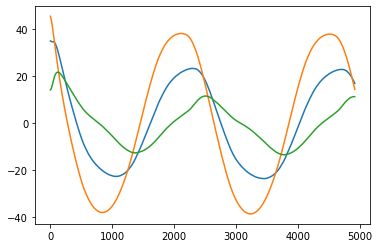

In [390]:
a=3.14/3
v = np.array([np.cos(a),np.sin(a)])
proj = np.dot(y[:,:2],v)
proj.shape

plt.plot(proj)
plt.plot(y[:,0])
plt.plot(y[:,1])

In [366]:
def orientation(data, angle=np.linspace(-1,0,100)*np.pi):
    ranges=[]
    for a in angle:
        v = np.array([np.cos(a),np.sin(a)])
        proj = np.dot(data,v)
#         print(proj.shape)
        ranges.append(proj.max()-proj.min())
    return ranges#angle[np.argmax(ranges)]

for i in np.arange(-30,0):
    y = pca.transform(x[i])
    c = plt.cm.viridis(i/x.shape[0])
    n=120*15
    plt.plot(orientation(y[:,:2]))

In [348]:
y.shape

(4920, 10)

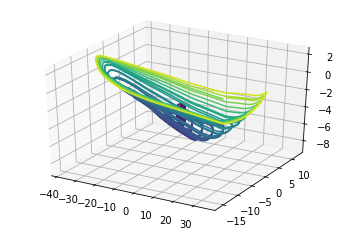

In [235]:
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in np.arange(0,x.shape[0],10):
    y = pca.transform(x[i])
    c = plt.cm.viridis(i/x.shape[0])
    n=120*15
    ax.plot(y[-n:,0],y[-n:,1],y[-n:,2],c=c)
plt.show()